## Install packages

In [1]:
!pip install git+https://github.com/huggingface/transformers -U
#!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-8aa56ue1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-8aa56ue1
  Resolved https://github.com/huggingface/transformers to commit 87134662f73d5e89bb015531ddd1d4662371d317
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.45.0.dev0-py3-none-any.whl size=9553761 sha256=49387ff5de1e175fe04b9260f841902332610bb929a69464e5c863a47dbac64d
  Stored in directory: /tmp/pip-ephem-wheel-cache-6gvht5or/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.3
    Uninstalling transformers-4.42.3:
      Successfully uninstalled transformers-4.42.3
Looking in indexes: https://pypi.org/sim

In [2]:
# !pip install -U sentence-transformers

In [3]:
#!pip install faiss-cpu
# !pip install faiss-gpu

## Imports

In [4]:
import pandas as pd
import numpy as np
import os
import ast

import torch
import gc

import sys, random, string, re, time
from transformers import (BitsAndBytesConfig, 
                          AutoModelForCausalLM, 
                          AutoTokenizer, pipeline)
from tqdm.auto import tqdm

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

print(f"CUDA Version: {torch.version.cuda}")
print(f"Pytorch {torch.__version__}")

2024-08-21 05:59:11.869296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 05:59:11.869409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 05:59:11.964983: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


CUDA Version: 12.1
Pytorch 2.1.2


In [5]:
torch.cuda.is_available()

True

In [6]:
# Set a seed value

import torch, random

# Ensure that all GPU operations are deterministic 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Define Variables

In [7]:
# set the path to the Gemma model hosted on Kaggle
MODEL_PATH = "/kaggle/input/gemma/transformers/7b-it/1"
MODEL_PATH_large = "/kaggle/input/gemma-2/transformers/gemma-2-27b-it/1"

# set the path to the data that will be used in the few shot prompt
FEW_SHOT_DATA_PATH = '../input/gemma-comp-data/df_corrected_data.csv'

# set the path the text files containing info about Kaggle
# KAGGLE_DATA_PATH = '../input/gemma-comp-data/rev4-cleaned-txt-kaggle/'

# the number of results from the vector search that will be reranked
TOP_K = 20

# the number of text chunks that will be passed to Gemma
NUM_CHUNKS_IN_CONTEXT = 3

## Define Device

In [8]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Device: {DEVICE}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"Pytorch {torch.__version__}")

Device: cuda
CUDA Version: 12.1
Pytorch 2.1.2


In [9]:
# Check the type and quantity of GPUs

if torch.cuda.is_available():
    print('Num CPUs:', os.cpu_count())
    print('Num GPUs:', torch.cuda.device_count())
    print('GPU Type:', torch.cuda.get_device_name(0))


Num CPUs: 4
Num GPUs: 2
GPU Type: Tesla T4


In [10]:
os.cpu_count()

4

## Helper functions

In [11]:
def run_faiss_search(query_text, top_k):
    
    """
    Executes an exhaustive search using FAISS to find the most 
    similar items to a given query.

    This function vectorizes the input query text using 
    a pre-defined model and then performs a search in a FAISS index 
    to retrieve the top_k most similar items. 
    It returns the indices of these items in the FAISS index, 
    which can be used to retrieve the corresponding documents
    or items.

    Parameters:
    - query_text (str): The text of the query for which similar 
    items are to be found.
    - top_k (int): The number of top similar items to retrieve.

    Returns:
    - index_vals_list (list of int): A list of indices for the top_k 
    most similar items found in the FAISS index. 
    These indices correspond to the positions of the items in 
    the dataset used to build the FAISS index.
    
    Note:
    - This function assumes that a FAISS index (`faiss_index`) 
    and a model for vectorization (`model`) are already defined 
    outside the function.
    - The function is designed for use with the Sentence Transformers
    package to convert text to vectors.
    
    """
    
    # Run FAISS exhaustive search
    query = [query_text]

    # Vectorize the query string
    query_embedding = model.encode(query, show_progress_bar=False)

    # Run the query
    # index_vals refers to the chunk_list index values
    scores, index_vals = faiss_index.search(query_embedding, top_k)
    
    # Get the list of index vals
    index_vals_list = index_vals[0]
    
    return index_vals_list
    

def run_rerank(index_vals_list, query_text):
    
    """
    Re-ranks a list of retrieved passages based on 
    their similarity to the input query using a cross-encoder.

    This function takes a list of index values corresponding to 
    retrieved passages and the input query text. 
    It then retrieves the actual text of these passages from a 
    dataframe (`df_data`) and formats them for input to a cross-encoder.
    The cross-encoder is then used to score the similarity between 
    each passage and the query. The passages are re-ranked
    based on these scores, and the re-ranked list of 
    passages is returned.

    Parameters:
    - index_vals_list (list of int): A list of index values 
    corresponding to retrieved passages.
    - query_text (str): The text of the query to be used 
    for re-ranking the passages.

    Returns:
    - pred_list (list of str): A list of re-ranked passages based 
    on their similarity to the query text.

    Note:
    - This function assumes that a dataframe (`df_data`) 
    containing the prepared text of passages and a 
    cross-encoder (`cross_encoder`) for scoring the similarity 
    between text pairs are already defined outside the function.
    """
    
    # Create a list of text chunks
    chunk_list = list(df_data['prepared_text'])

    # Replace the chunk index values with the corresponding strings
    pred_strings_list = [chunk_list[item] for item in index_vals_list]

    # Format the input for the cross encoder
    # The input to the cross_encoder is a list of lists
    # [[query_text, pred_text1], [query_text, pred_text2], ...]

    cross_input_list = []

    for item in pred_strings_list:
        
        # Create a question/chunk pair: [question, text_chunk]
        new_list = [query_text, item]
        
        # Append to the list containing all the question/chunk pairs
        # [[question, text_chunk], [question, text_chunk], ...]
        cross_input_list.append(new_list)


    # Put the pred text into a dataframe
    df = pd.DataFrame(cross_input_list, 
                      columns=['query_text', 'pred_text'])

    # Save the orginal index (i.e. df_data index values)
    df['original_index'] = index_vals_list

    # Now, score all retrieved passages using the cross_encoder
    cross_scores = cross_encoder.predict(cross_input_list, show_progress_bar=False)

    # Add the scores to the dataframe
    df['cross_scores'] = cross_scores

    # Sort the DataFrame in descending order based on the scores
    df_sorted = df.sort_values(by='cross_scores', ascending=False)
    
    # Reset the index
    df_sorted = df_sorted.reset_index(drop=True)

    pred_list = []

    for i in range(0,len(df_sorted)):
        
        # Get the text
        text = df_sorted.loc[i, 'pred_text']
        
        # Add curly braces
        item = {
            text
        }

        # Appen the text to a list
        pred_list.append(item)

    return pred_list

    

def vector_search_and_rerank(query_text, top_k=10):
    
    """
    Executes a retrieval-augmented generation (RAG) system 
    to generate responses to a given query.

    This function integrates FAISS for initial retrieval and 
    re-ranking using a cross-encoder to produce a list of responses 
    to the input query text. 
    First, it runs a FAISS exhaustive search to retrieve the top_k 
    most relevant passages based on the query. 
    Then, it re-ranks these passages using a cross-encoder
    to prioritize those with the highest similarity to the query. 
    The resulting list of passages is returned as the 
    output of the RAG system.

    Parameters:
    - query_text (str): The text of the query for which responses 
    are to be generated.
    - top_k (int, optional): The number of top passages to 
    retrieve and re-rank. Defaults to 10.

    Returns:
    - pred_list (list of str): A list of passages ranked and 
    generated by the RAG system in response to the query.

    Note:
    - This function assumes that `run_faiss_search` and `run_rerank` 
    functions are already defined. 
    These functions handle the initial retrieval and 
    re-ranking processes, respectively.
    """
    
    # Run a faiss exhaustive search
    pred_index_list = run_faiss_search(query_text, top_k)

    # This returns a list of dicts with length equal to top_k
    pred_list = run_rerank(pred_index_list, query_text)
    
    return pred_list

 

def extract_gemma_response(response):
    
    # Extract the answer:
    # Split and select the last item in the list
    response = response.split('<start_of_turn>model')[-1]
    # Remove leading and trailing spaces
    response = response.strip()
    # Remove the '<end_of_turn> token
    response = response.replace('<end_of_turn>', "")

    # Gemma always uses the phrase "I cannot answer this question"
    # when the answer is not available.
    text1 = 'I cannot answer this question'
    
    # If Gemma can't answer the question then
    # output a standard response.
    if text1 in response:
        response = "Sorry, that information is not available."
        
    return response


def format_text(text):

    # Create a list
    answer_list = text.split('\n')

    for i, item in enumerate(answer_list):

        # Replace * with nothing
        new_item = item.replace('*','')
        
        # Remove leading and trailing spaces
        new_item = new_item.strip()

        # Create the output string
        if i == 0:  
            fin_string = new_item + '\n'
        else:
            fin_string = fin_string + new_item + '\n'

    return fin_string


def gemma_assistant(question):
    
    # Create the prompt
    prompt = f"""<start_of_turn>user 
    Don't use Mardown to format your response.
    {question}<end_of_turn>
    <start_of_turn>model
    """

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    # Generate the outputs from prompt
    generate_ids = gemma_model.generate(**inputs, max_new_tokens=768)
    # Decode the generated output
    generated_text = tokenizer.batch_decode(generate_ids, 
                                        skip_special_tokens=True,
                                        clean_up_tokenization_spaces=False)[0]


    # Extract the answer
    response = generated_text.split('<start_of_turn>model')[-1]
    # Remove leading and trailing spaces
    response = response.strip()
    # Remove the '<end_of_turn> token
    response = response.replace('<end_of_turn>', "")
    
    # Remove markdown '*' symbols
    response = format_text(response)
    
    return response


def timer(start_time):

    # End timing
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    # round to one decimal place
    elapsed_time = round(elapsed_time, 1)
    
    return elapsed_time

## Initialize Gemma 7b-it
There are three important capabilities that LLMs have - knowledge, reasoning and reading comprehension. I experimented with both gemma-2b-it (trained on 2T tokens) and gemma-7b-it (trained on 6T tokens).

I chose the larger gemma-7b-it for this solution because it has a better reasoning ability and better reading comprehension. When both models are given the same reference text and asked to extract an answer to a question, gemma-7b-it more often produced the correct answer.

We will use the HuggingFace Transformers package to load the model and run inference. We will also use the bitsandbytes package to reduce the size of the model by using 4-bit precision. This will allow it to fit in the memory (RAM) available in this notebook environment.

We are using two T4 GPUs.
You will note that in the code below we have set: device_map="auto"
This feature of the Transformers package automatically takes care of of distributing the model across both GPUs.

In [12]:
# Initialize the model and the tokenizer.
# (This step takes about 2 minutes)


# Set the compute data type to 16-bit floating point (float16).
# This is a more memory-efficient format than float32, 
# It lowers memory usage and can speed up computation.
compute_dtype = getattr(torch, "float16")


# Configure the model to use 4-bit precision for certain weights, 
# and specify the quantization details. This further reduces the 
# model size and can speed up inference.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

# Load the causal language model with the defined quantization 
# configuration and set it to automatically map 
# to the available device.
gemma_model = AutoModelForCausalLM.from_pretrained(MODEL_PATH,
                                        device_map="auto",
                                        quantization_config=bnb_config)

# Disable caching of past key values for transformer models.
# This reduces memory usage in scenarios where past key values 
# aren't needed for subsequent predictions.
gemma_model.config.use_cache = False

# Set the pretraining throughput to 1.
gemma_model.config.pretraining_tp = 1

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
gemma_model.config

GemmaConfig {
  "_name_or_path": "/kaggle/input/gemma/transformers/7b-it/1",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 24576,
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 16,
  "num_hidden_layers": 28,
  "num_key_value_heads": 16,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "

## Ask Gemma questions about Some Questions

Let's ask Gemma a few questions about esports. Gemma would have gained this knowledge during training.

It's important to use a good prompt template when working with Gemma. If we don't then we might get bad outputs. The prompt template we will be using is explained here:
https://www.promptingguide.ai/models/gemma

In [14]:
ques = "What is Esports?"

# Create a Prompt
prompt = f"""<start_of_turn>user
{ques}<end_of_turn>
<start_of_turn>model
"""
# prompt
# Start timing
start_time = time.time()

## Tokenize the prompt
inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

generate_ids = gemma_model.generate(**inputs, max_new_tokens=768)

# DEcode the generated output
generated_text = tokenizer.batch_decode(generate_ids, 
                                    skip_special_tokens=True,
                                    clean_up_tokenization_spaces=False)[0]

# Extract the answer

# Split and select the last item in the list
response = generated_text.split('<start_of_turn>model')[-1]
# Remove leading and trailing spaces
response = response.strip()
# Remove the '<end_of_turn> token
response = response.replace('<end_of_turn>', "")

# Remove markdown '*' symbols
# The deafult Markdown that Gemma outputs
# doesn't always display well.
response = format_text(response)


# Get the inference time
elapsed_time = timer(start_time)
print(f"Time taken: {elapsed_time} seconds")

print()
print('User:\n',ques)
print()
print('Gemma:\n', response)


Time taken: 4.1 seconds

User:
 What is Esports?

Gemma:
 Esports is a term used to describe competitive video gaming events. It is a relatively new term, but it has become increasingly popular in recent years. Esports events are held all over the world, and they can be watched by millions of people.



In [15]:
# # Start timing
# start_time = time.time()

# question = "What is the condition of esports in Bangladesh?"

# answer = gemma_assistant(question)


# # Get the inference time
# elapsed_time = timer(start_time)
# print(f"Time taken: {elapsed_time} seconds")
# print()

# print('User:\n',question)
# print()
# print('Gemma:\n',answer)

In [16]:
# Start timing
# start_time = time.time()

# question = "Name one esports organization from Bangladesh."

# answer = gemma_assistant(question)


# # Get the inference time
# elapsed_time = timer(start_time)
# print(f"Time taken: {elapsed_time} seconds")
# print()

# print('User:\n',question)
# print()
# print('Gemma:\n',answer)

In [17]:
# question = "Who is prime minister of Bangladesh?"

# answer = gemma_assistant(question)

# print('User:\n',question)
# print()
# print('Gemma:\n',answer)

## Read the Data Set

In [18]:
df = pd.read_parquet('/kaggle/input/esports-data/live_comments_2/bangladesh_livechat_data.parquet')

df.head(3)

,datetime,author,message,video_id
0,2022-08-12 09:22:22,Rizvan,hii,oiqpD3C_dLo
1,2022-08-12 09:22:35,Rizvan,#2d,oiqpD3C_dLo
2,2022-08-12 09:25:29,RN KAKASHI,3rd,oiqpD3C_dLo


In [19]:
context = """ I'm familiar with a few esports organizations from Bangladesh. Here are a couple of notable ones:

A1 Esports: A1 Esports is one of the prominent esports organizations in Bangladesh. They are well-known for their presence in competitive gaming, particularly in PUBG Mobile, where they've had significant success both locally and internationally.
FS-Gaming (FsGSM): FS-Gaming is another well-known esports organization in Bangladesh. They have participated in various esports tournaments and are recognized in the local gaming community.
These organizations are part of the growing esports scene in Bangladesh, which is gaining more attention and support over time.
"""

context

" I'm familiar with a few esports organizations from Bangladesh. Here are a couple of notable ones:\n\nA1 Esports: A1 Esports is one of the prominent esports organizations in Bangladesh. They are well-known for their presence in competitive gaming, particularly in PUBG Mobile, where they've had significant success both locally and internationally.\nFS-Gaming (FsGSM): FS-Gaming is another well-known esports organization in Bangladesh. They have participated in various esports tournaments and are recognized in the local gaming community.\nThese organizations are part of the growing esports scene in Bangladesh, which is gaining more attention and support over time.\n"

In [20]:
ques = "Name some Esports organization from Bangladesh."

In [21]:
# Create the prompt
prompt = f"""<start_of_turn>user
Context: {context}
Question: {ques}<end_of_turn>
<start_of_turn>model
"""

    
# Tokenize the prompt
inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
# Generate the outputs from prompt
generate_ids = gemma_model.generate(**inputs, max_new_tokens=768)
# Decode the generated output
response = tokenizer.batch_decode(generate_ids, skip_special_tokens=True,
                                     clean_up_tokenization_spaces=False)[0]


# Extract the answer

# Split and select the last item in the list
gemma_response = response.split('<start_of_turn>model')[-1]
# Remove leading and trailing spaces
gemma_response = gemma_response.strip()
# Remove the '<end_of_turn> token
gemma_response= gemma_response.replace('<end_of_turn>', "")

# Get the inference time
elapsed_time = timer(start_time)
print(f"Time taken: {elapsed_time} seconds")
print()

print('-----')
print('User:\n',ques)
print()
print('Raw Gemma response:\n\n',response)
print()
print()
print('Extracted Gemma response:\n\n',gemma_response)

Time taken: 8.7 seconds

-----
User:
 Name some Esports organization from Bangladesh.

Raw Gemma response:

 <start_of_turn>user
Context:  I'm familiar with a few esports organizations from Bangladesh. Here are a couple of notable ones:

A1 Esports: A1 Esports is one of the prominent esports organizations in Bangladesh. They are well-known for their presence in competitive gaming, particularly in PUBG Mobile, where they've had significant success both locally and internationally.
FS-Gaming (FsGSM): FS-Gaming is another well-known esports organization in Bangladesh. They have participated in various esports tournaments and are recognized in the local gaming community.
These organizations are part of the growing esports scene in Bangladesh, which is gaining more attention and support over time.

Question: Name some Esports organization from Bangladesh.<end_of_turn>
<start_of_turn>model
Sure, here are the named Esports organization from Bangladesh in the text:

- A1 Esports
- FS-Gaming (F

In [22]:
def hello_world(question, context):   
    # Create the prompt
    prompt = f"""<start_of_turn>user
    Context: {context}
    Question: {question}<end_of_turn>
    <start_of_turn>model
    """


    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    # Generate the outputs from prompt
    generate_ids = gemma_model.generate(**inputs, max_new_tokens=768)
    # Decode the generated output
    response = tokenizer.batch_decode(generate_ids, skip_special_tokens=True,
                                         clean_up_tokenization_spaces=False)[0]


    # Extract the answer

    # Split and select the last item in the list
    gemma_response = response.split('<start_of_turn>model')[-1]
    # Remove leading and trailing spaces
    gemma_response = gemma_response.strip()
    # Remove the '<end_of_turn> token
    gemma_response= gemma_response.replace('<end_of_turn>', "")
    
    # Clear the memory to create space
    del prompt
    del inputs
    del generate_ids
    torch.cuda.empty_cache() 
    gc.collect()
        
    return gemma_response

In [23]:
context = f"""
COVID-19, caused by the SARS-CoV-2 virus, emerged in late 2019 and rapidly became a global pandemic. Characterized by respiratory symptoms, fever, and fatigue, the virus spread across the world, leading to millions of infections and significant mortality. Governments implemented lockdowns, social distancing, and mask mandates to curb the spread, while scientists raced to develop vaccines. The pandemic disrupted daily life, economies, and healthcare systems, highlighting the importance of public health infrastructure. Vaccination efforts and public health measures eventually helped control the virus, though its long-term impact continues to be felt globally.
"""
ques = "Whaat is covid 19?"

print(context)
print(ques)


COVID-19, caused by the SARS-CoV-2 virus, emerged in late 2019 and rapidly became a global pandemic. Characterized by respiratory symptoms, fever, and fatigue, the virus spread across the world, leading to millions of infections and significant mortality. Governments implemented lockdowns, social distancing, and mask mandates to curb the spread, while scientists raced to develop vaccines. The pandemic disrupted daily life, economies, and healthcare systems, highlighting the importance of public health infrastructure. Vaccination efforts and public health measures eventually helped control the virus, though its long-term impact continues to be felt globally.

Whaat is covid 19?


In [24]:
ans = hello_world(ques, context)
print(ques)

print(ans)

Whaat is covid 19?
Sure, here is the answer to the question:

COVID-19, caused by the SARS-CoV-2 virus, is a viral infection that emerged in late 2019 and quickly spread worldwide, becoming a global pandemic. It is characterized by respiratory symptoms, fever, and fatigue. The virus has caused millions of infections and significant mortality. Governments implemented lockdowns, social distancing, and mask mandates to curb the spread, while scientists raced to develop vaccines. The pandemic disrupted daily life, economies, and healthcare systems, highlighting the importance of public health infrastructure. Vaccination efforts and public health measures eventually helped control the virus, though its long-term impact continues to be felt globally.


In [25]:
ques = "Give three topics from this context. Not any Description Just the topics."
ans = hello_world(ques, context)
print(ques)

print(ans)

Give three topics from this context. Not any Description Just the topics.
Sure, here are the three topics from the provided text:

    1. COVID-19 pandemic and its impact on global health
    2. Vaccination efforts and public health measures
    3. The importance of public health infrastructure


In [26]:
# context_text = f"""
# A mother is often seen as the heart of the family, offering unconditional love, care, and support. She nurtures and guides her children, providing them with the foundation they need to grow into confident and compassionate individuals. A mother's role goes beyond just caregiving; she imparts values, offers wisdom, and serves as a source of comfort and strength throughout her children's lives. Her influence is profound, shaping not only the lives of her children but also the future of the family.
# """
# ans = hello_world(ques, context_text)
# print(ques)

# print(ans)

## Use the Chat Data

In [27]:
df.head(3)

,datetime,author,message,video_id
0,2022-08-12 09:22:22,Rizvan,hii,oiqpD3C_dLo
1,2022-08-12 09:22:35,Rizvan,#2d,oiqpD3C_dLo
2,2022-08-12 09:25:29,RN KAKASHI,3rd,oiqpD3C_dLo


In [28]:
import emoji

def replace_emoji_codes(text):
    """
    Replace text-based emoji codes with actual emojis using the `emoji` library.

    Parameters:
    - text (str): The input text containing emoji codes.

    Returns:
    - str: The text with emoji codes replaced by actual emojis.
    """
    # Convert text-based emoji codes to actual emojis
    return emoji.emojize(text)

# Example usage
text = "A1 :red_heart: A1 :red_heart:"
converted_text = replace_emoji_codes(text)
print(converted_text)  # Output: "A1 ❤️ A1 ❤️"

A1 ❤️ A1 ❤️


In [29]:
from tqdm import tqdm
tqdm.pandas()
df['message'] = df.message.progress_apply(replace_emoji_codes)

100%|██████████| 2796193/2796193 [00:30<00:00, 91770.58it/s] 


In [30]:
len(df)

2796193

In [31]:
# # filt = df[:10].copy()

fkchat = df['message']

# demo1 = fkchat[:100]
# msg = ", ".join(demo1.astype(str))
# msg

In [32]:
# context = msg
# # print(context)

# ques = "These are some live Chats from a Esports Live. Now Give me 2 short key topics from these chats. No Description just the topic please. Nothing else just the two topic name."


In [33]:
# ans = hello_world(ques, context)

# print(ques, end='\n')

# print(ans)

In [34]:
# x = 100
# demo1 = fkchat[x:x+100]
# msg = ", ".join(demo1.astype(str))
# msg

In [35]:
# context = msg
# ans = hello_world(ques, context)

# print(ques, end='\n')

# print(ans)

In [36]:
# x = 200
# demo1 = fkchat[x:x+100]
# msg = ", ".join(demo1.astype(str))
# context = msg
# ans = hello_world(ques, context)
# print(ans)

## Apply it in a Loop

In [37]:
# x = 0
# chunk_size = 100
# results = []

# # lim = len(fkchat)
# lim = 1000

# total_iterations = (lim - x) // chunk_size

# # Loop through the DataFrame in chunks of 100 with a progress bar
# for _ in tqdm(range(total_iterations), desc="Processing"):
#     # Get the next 100 messages
#     demo1 = fkchat[x:x + chunk_size]
    
#     # Convert the messages to a single string, separated by commas
#     msg = ", ".join(demo1.astype(str))
    
#     # Pass the context to the hello_world function and store the result
#     ans = hello_world(ques, msg)
#     lines = ans.splitlines()

#     # Rejoin the lines, skipping the first one
#     new_text = "\n".join(lines[1:])

#     results.append(new_text)
    
#     # Move to the next chunk
#     x += chunk_size

In [38]:
# for v in results:
#     print(v)

In [39]:
# results[0]

In [40]:
import re

text = "\n    - Soul se. nehi ho payega 🤣\n    - Ste and A1 sinister"

# Split the text into separate lines based on newline
separated_texts = [line.strip() for line in text.split('\n') if line.strip()]

# Remove leading hyphens, numbers, or other unwanted characters
cleaned_texts = [re.sub(r'^[\d\-\s]+', '', line) for line in separated_texts]

# Now you have cleaned lines as separate values in a list
print(cleaned_texts)


['Soul se. nehi ho payega 🤣', 'Ste and A1 sinister']


In [41]:
import re
import string

def cln_texts(text):
    # Split the text into separate lines based on newline
    separated_texts = [line.strip() for line in text.split('\n') if line.strip()]

    # Remove leading hyphens, numbers, or other unwanted characters
    cleaned_texts = [re.sub(r'^[\d\-\s]+', '', line) for line in separated_texts]

    # Remove punctuation
    cleaned_texts = [line.translate(str.maketrans('', '', string.punctuation)) for line in cleaned_texts]
    
    # Remove extra spaces
    cleaned_texts = [re.sub(r'\s+', ' ', line).strip() for line in cleaned_texts]
    
    return cleaned_texts

In [42]:
# farr = []
# for v in tqdm(results):
#     farr.append(cln_texts(v))
    
# farr = [item for sublist in farr for item in sublist]

In [43]:
# farr

## Now Apply for big chunks

In [44]:
x = 500_000
chunk_size = 100
ult_results = []

# lim = len(fkchat)
lim = x+20_0

total_iterations = (lim - x) // chunk_size

# Loop through the DataFrame in chunks of 100 with a progress bar
for _ in tqdm(range(total_iterations), desc="Processing"):
    # Get the next 100 messages
    demo1 = fkchat[x:x + chunk_size]
    
    # Convert the messages to a single string, separated by commas
    msg = ", ".join(demo1.astype(str))
    
    try:
        # Pass the context to the hello_world function and store the result
        ans = hello_world(ques, msg)
        lines = ans.splitlines()

        # Rejoin the lines, skipping the first one
        new_text = "\n".join(lines[1:])

        ult_results.append(new_text)
    except:
        ult_results.append('None')

    
    # Move to the next chunk
    x += chunk_size

Processing: 100%|██████████| 2/2 [00:08<00:00,  4.25s/it]


In [45]:
# ult_results

In [46]:
farr = []
for v in tqdm(ult_results):
    farr.append(cln_texts(v))
    
farr = [item for sublist in farr for item in sublist]

100%|██████████| 2/2 [00:00<00:00, 8612.53it/s]


In [47]:
farr[:10]

['Gaming and Esports',
 'Community and Friendships',
 'Miscellaneous Topics',
 'Gaming and Esports',
 'Social Media and Community',
 'Personal Stories and Experiences']

In [48]:
topic_df = pd.DataFrame({'topic': farr})

print(topic_df.shape)

(6, 1)


In [49]:
topic_df.head()

,topic
0,Gaming and Esports
1,Community and Friendships
2,Miscellaneous Topics
3,Gaming and Esports
4,Social Media and Community


In [50]:
topic_df.tail()

,topic
1,Community and Friendships
2,Miscellaneous Topics
3,Gaming and Esports
4,Social Media and Community
5,Personal Stories and Experiences


In [51]:
filt = topic_df[topic_df['topic']=='None']
print(filt.shape)

(0, 1)


In [52]:
topic_df.to_csv('All_topicsp4.csv', index=False)

## Shorten The Topic List

In [64]:
import os
import pandas as pd

# Directory containing the CSV files
folder_path = '/kaggle/input/esports-data/topics/'

# List all files in the directory
all_files = os.listdir(folder_path)

# Filter out the files that end with '.csv'
csv_files = [f for f in all_files if f.endswith('.csv')]

# Initialize a list to store DataFrames
dfs = []

# Loop over each CSV file and read it into a DataFrame
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# If you want to concatenate all DataFrames into one:
tdf = pd.concat(dfs, ignore_index=True)

In [66]:
print(tdf.shape)

tdf.head(3)

(10003, 1)


,topic
0,Gaming and Esports
1,Community and Support
2,Personal Stories


In [81]:
larr = tdf['topic']

In [70]:
tarr = tdf['topic'].tolist()

print(len(tarr))
tarr[:5]

10003


['Gaming and Esports',
 'Community and Support',
 'Personal Stories',
 'Boycott Sinister',
 'A1 Fans Emotions']

In [77]:
topics = ', '.join(tarr[:100])

In [76]:
ques = "There are similar type of topics in this context list. From these topics give me top 5 topics."

In [79]:
ans = hello_world(ques, topics)
print(ans)

Sure, here are the top 5 topics from the provided text:

1. Gaming and Esports
2. A1 and Gsm Vai vai
3. Boycott Sinister
4. Hate speech and its impact on the community
5. Personal anecdotes and humor


In [89]:
x = 0
chunk_size = 100
tp_results = []

lim = len(tarr)
# lim = x+10000

total_iterations = (lim - x) // chunk_size

# Loop through the DataFrame in chunks of 100 with a progress bar
for _ in tqdm(range(total_iterations), desc="Processing"):
    # Get the next 100 messages
    demo1 = larr[x:x + chunk_size]
    
    # Convert the messages to a single string, separated by commas
    msg = ", ".join(demo1.astype(str))
    
    try:
        # Pass the context to the hello_world function and store the result
        ans = hello_world(ques, msg)
        lines = ans.splitlines()

        # Rejoin the lines, skipping the first one
        new_text = "\n".join(lines[1:])

        tp_results.append(new_text)
    except:
        tp_results.append('None')

    
    # Move to the next chunk
    x += chunk_size

Processing: 100%|██████████| 100/100 [07:55<00:00,  4.76s/it]


In [90]:
tp_results[:5]

['\n1. Gaming and Esports\n2. A1 and Gsm Vai vai\n3. Boycott Sinister\n4. Hate speech and its impact on the community\n5. Personal anecdotes and humor',
 '\n1. Gaming and Esports\n2. Personal and Emotional Topics\n3. Cricket Discussion\n4. Social Interactions\n5. Miscellaneous Topics',
 '\n1. Gaming and Esports\n2. Personal and Social\n3. Team discussions and strategies\n4. Commentary and humor\n5. Miscellaneous topics',
 '\n1. Gaming and Entertainment\n2. Personal anecdotes\n3. Food and drinks\n4. Conversation between friends\n5. Miscellaneous topics',
 '\n1. Gaming and Esports\n2. Bangladeshi Public and their understanding of English\n3. Social Media and Public Understanding\n4. Gaming and Entertainment\n5. Miscellaneous Topics']

In [91]:
tp_results[0]

# Split the text into separate lines, remove leading/trailing whitespace, and filter out empty lines
lines = [line.strip() for line in tp_results[0].split('\n') if line.strip()]

# Remove the numbering (e.g., "1.", "2.") and create the final list
final_list = [re.sub(r'^\d+\.\s*', '', line) for line in lines]

print(final_list)


['Gaming and Esports', 'A1 and Gsm Vai vai', 'Boycott Sinister', 'Hate speech and its impact on the community', 'Personal anecdotes and humor']


In [99]:
new_tp=[]
for i, val in enumerate(tp_results):
    text = tp_results[i]
    # Split the text into separate lines, remove leading/trailing whitespace, and filter out empty lines
    lines = [line.strip() for line in text.split('\n') if line.strip()]

    # Remove the numbering (e.g., "1.", "2.") and create the final list
    new_tp.append([re.sub(r'^\d+\.\s*', '', line) for line in lines])
    
new_tp = [item for sublist in new_tp for item in sublist]

In [102]:
print(len(new_tp))
new_tp[:10]

510


['Gaming and Esports',
 'A1 and Gsm Vai vai',
 'Boycott Sinister',
 'Hate speech and its impact on the community',
 'Personal anecdotes and humor',
 'Gaming and Esports',
 'Personal and Emotional Topics',
 'Cricket Discussion',
 'Social Interactions',
 'Miscellaneous Topics']

In [103]:
top500 = pd.DataFrame({'topic': new_tp})

print(top500.shape)

(510, 1)


In [104]:
top500.to_csv('top_500_topic.csv', index=False)

## From top 500 to top 25

In [105]:
fh = top500['topic']

In [118]:
ques = "There are similar type of topics in this context list. From these topics give me top 5 topics. Just the topic no description."

In [121]:
x = 0
chunk_size = 50
tp_results = []

lim = len(fh)
# lim = x+10000

total_iterations = (lim - x) // chunk_size

# Loop through the DataFrame in chunks of 100 with a progress bar
for _ in tqdm(range(total_iterations), desc="Processing"):
    # Get the next 100 messages
    demo1 = fh[x:x + chunk_size]
    
    # Convert the messages to a single string, separated by commas
    msg = ", ".join(demo1.astype(str))
    
    try:
        # Pass the context to the hello_world function and store the result
        ans = hello_world(ques, msg)
        lines = ans.splitlines()

        # Rejoin the lines, skipping the first one
        new_text = "\n".join(lines[1:])

        tp_results.append(new_text)
    except:
        tp_results.append('None')

    
    # Move to the next chunk
    x += chunk_size

Processing: 100%|██████████| 10/10 [00:30<00:00,  3.03s/it]


In [122]:
tp_results

['    2. Personal and Emotional Topics\n    3. Cricket Discussion\n    4. Social Interactions\n    5. Hate Speech and its Impact on Society',
 '    2. Cricket and Bangladesh\n    3. Sports and Recreation\n    4. Personal and Community\n    5. Miscellaneous Topics',
 '    2. Personal Stories and Experiences\n    3. Social Interactions and Humor\n    4. Community and Social Interaction\n    5. Team Discussions and Strategies',
 '    2. Personal and Community\n    3. Team Game Discussion\n    4. Esports News and Discussion\n    5. Match Discussion',
 '    2. Nan\n    3. Nan\n    4. Nan\n    5. Nan',
 '    2. Nan\n    3. Nan\n    4. Nan\n    5. Nan',
 '    2. Personal and Community\n    3. Sports and Entertainment\n    4. Hate Speech and Spreading Hate\n    5. Team Up Operations',
 '    2. Nan\n    3. Nan\n    4. Nan\n    5. Nan',
 '    2. Gaming and Esports\n    3. Team Building and Qualification\n    4. Community and Social Interaction\n    5. Miscellaneous Topics',
 '    2. Gaming and E

In [123]:
new_tp=[]
for i, val in enumerate(tp_results):
    text = tp_results[i]
    # Split the text into separate lines, remove leading/trailing whitespace, and filter out empty lines
    lines = [line.strip() for line in text.split('\n') if line.strip()]

    # Remove the numbering (e.g., "1.", "2.") and create the final list
    new_tp.append([re.sub(r'^\d+\.\s*', '', line) for line in lines])
    
new_tp = [item for sublist in new_tp for item in sublist]

In [124]:
new_tp

['Personal and Emotional Topics',
 'Cricket Discussion',
 'Social Interactions',
 'Hate Speech and its Impact on Society',
 'Cricket and Bangladesh',
 'Sports and Recreation',
 'Personal and Community',
 'Miscellaneous Topics',
 'Personal Stories and Experiences',
 'Social Interactions and Humor',
 'Community and Social Interaction',
 'Team Discussions and Strategies',
 'Personal and Community',
 'Team Game Discussion',
 'Esports News and Discussion',
 'Match Discussion',
 'Nan',
 'Nan',
 'Nan',
 'Nan',
 'Nan',
 'Nan',
 'Nan',
 'Nan',
 'Personal and Community',
 'Sports and Entertainment',
 'Hate Speech and Spreading Hate',
 'Team Up Operations',
 'Nan',
 'Nan',
 'Nan',
 'Nan',
 'Gaming and Esports',
 'Team Building and Qualification',
 'Community and Social Interaction',
 'Miscellaneous Topics',
 'Gaming and Esports',
 'Personal and Team-related topics',
 'Community and Social Interactions',
 'Personal Interests and Experiences']

In [129]:
topics = [topic for topic in topics if topic != 'Nan']

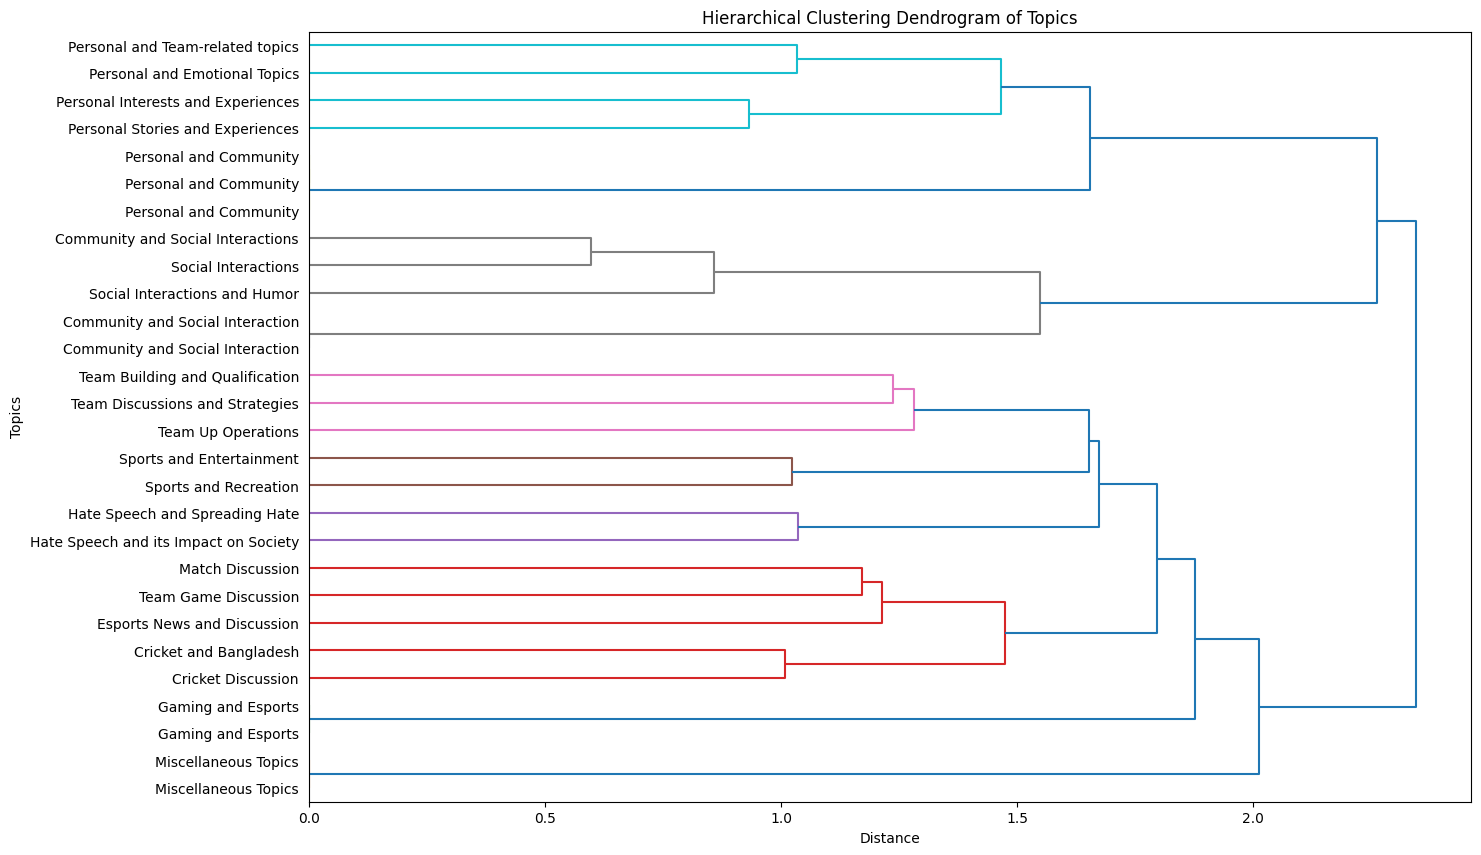

In [130]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the topics into numerical vectors using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(topics)

# Perform hierarchical clustering
Z = linkage(X.toarray(), method='ward')

# Plot the hierarchical clustering as a dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=topics, orientation='right', leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram of Topics')
plt.xlabel('Distance')
plt.ylabel('Topics')
plt.show()


In [132]:
# Z

## Few Shot Prompting

In [58]:
# # Load the few shot data into a pandas dataframe
# df_fshot = pd.read_csv(FEW_SHOT_DATA_PATH)

# def convert_to_list(x):
    
#     # Convert the string to a list: '[...]' to [...]
#     x_as_list = ast.literal_eval(x)
    
#     return x_as_list

# # Convert each item in the context column from a string to a 
# # python list i.e. '[...]' to [...]
# df_fshot['gem_context'] = df_fshot['gem_context'].apply(convert_to_list)

# df_fshot.head()

In [59]:
# print(df_fshot.shape)
# df_fshot.tail(3)

In [60]:
# def hello_world_again(question, context):   
#     # Create the prompt
#     prompt = f"""<start_of_turn>user
#     Context: {df_fshot.loc[0, 'gem_context']}
#     Question: {df_fshot.loc[0, 'query']}<end_of_turn>
#     <start_of_turn>model
#     {df_fshot.loc[0, 'corrected_text']}<end_of_turn>
#     <start_of_turn>user
#     Context: {df_fshot.loc[5, 'gem_context']}
#     Question: {df_fshot.loc[5, 'query']}<end_of_turn>
#     <start_of_turn>model
#     {df_fshot.loc[5, 'corrected_text']}<end_of_turn>
#     <start_of_turn>user
#     Context: {df_fshot.loc[6, 'gem_context']}
#     Question: {df_fshot.loc[6, 'query']}<end_of_turn>
#     <start_of_turn>model
#     {df_fshot.loc[6, 'corrected_text']}<end_of_turn>
#     <start_of_turn>user
#     Think and write your step-by-step reasoning before responding.
    
#     Context: {context}
#     Question: {question}<end_of_turn>
#     <start_of_turn>model
#     """


#     # Tokenize the prompt
#     inp = tokenizer(prompt, return_tensors="pt").to(DEVICE)
#     # Generate the outputs from prompt
#     generate_ids = gemma_model.generate(**inp, max_new_tokens=768)
#     # Decode the generated output
#     response = tokenizer.batch_decode(generate_ids, skip_special_tokens=True,
#                                          clean_up_tokenization_spaces=False)[0]


#     # Extract the answer

#     # Split and select the last item in the list
#     gemma_response = response.split('<start_of_turn>model')[-1]
#     # Remove leading and trailing spaces
#     gemma_response = gemma_response.strip()
#     # Remove the '<end_of_turn> token
#     gemma_response= gemma_response.replace('<end_of_turn>', "")
    
#     return gemma_response

In [61]:
# ans = hello_world_again(ques, context)
# print(ques)
# print(ans)

In [62]:
# ans = hello_world_again(ques, context_text)
# print(ques)
# print(ans)